# Computing viscous flow about a moving body

In [1]:
using ViscousFlow

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
using LinearAlgebra

### Set the flow parameters and the body shape

In [4]:
Re = 200; # Reynolds number
U = 0.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body

In [5]:
n = 51;
body = Bodies.Plate(1.0,n)

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Transform the body with a specified initial position and orientation.

In [6]:
cent = (0.0,0.0)
α = 0.0
T! = RigidTransform(cent,α)    
T!(body) # transform the body to the current configuration

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


### Set the motion to oscillatory pitch-heave kinematics

In [7]:
let a = 0.25, # location of pitch axis, a = 0.5 is leading edge
    ϕp = -π/2,  # phase lag of pitch
    ϕh = 0.0,  # phase lag of heave
    A = 0.25,  # amplitude/chord
    fstar = 1/π, # fc/U
    α₀ = 0, # mean angle of attack
    Δα = 10π/180, # amplitude of pitching
    U₀ = 0.0, # translational motion (set to zero in place of free stream)
    K = π*fstar # reduced frequency, K = πfc/U

    oscil1 = RigidBodyMotions.PitchHeave(U₀,a,K,ϕp,α₀,Δα,A,ϕh);
    global motion = RigidBodyMotion(oscil1)
end

Rigid Body Motion:
  ċ = 0.0 - 0.09im
  c̈ = 0.03 - 1.0im
  α̇ = 0.35
  α̈ = 0.0
  Oscillatory pitch-heave kinematics with
     Reduced frequency K = 1.0
     Heaving amplitude A = 0.25
     Pitching amplitude Δα = 0.17453292519943295
     Pitch lag ϕp = -1.5707963267948966
     Heave lag ϕh = 0.0


This creates a function that can be evaluated for the current time's body motion parameters. The linear position, velocity, and acceleration (in complex notation), followed by the angle, angular velocity, and angular acceleration:

In [8]:
motion(1.0)

(-0.24685829825246003 - 0.1435459559519235im, -0.0057392178677753355 - 0.4187894229847506im, -0.019871824117229386 + 0.5736884886473416im, 0.15870233978020357, -0.14526264939012612, -0.6348093591208143)

### Let's set up the domain

In [9]:
xlim = (-1.0,1.0)
ylim = (-1.0,1.0);

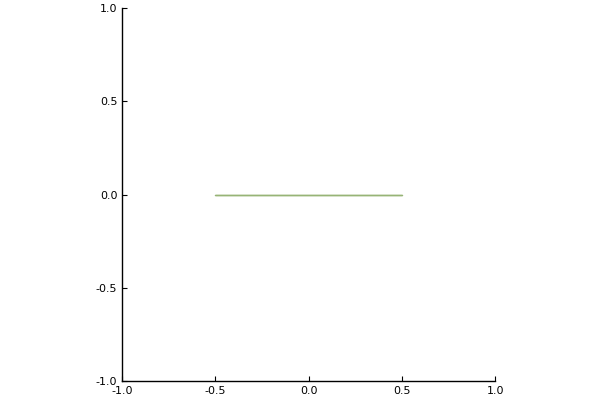

In [10]:
plot(body,xlim=xlim,ylim=ylim)

Now set up the coordinate data for operator construction

In [11]:
X = VectorData(collect(body));

Set the grid spacing and time step size

In [12]:
Δx = 0.02
cfl = 0.5
Δt = min(cfl*Δx,0.5*Δx^2*Re)

0.01

### Constructing operators and the solution structures
We will solve this problem with a state vector that consists of the fluid vorticity field and the configuration vector of the body. The fluid vorticity field will be evolved by the Navier-Stokes equations, constrained by the no-slip condition on the body. The body configuration will be updated by its prescribed motion. This configuration and prescribed motion will also be used by the fluid solution.

#### Set up the state vector and constraint force vector for a moving body

In [13]:
sys = NavierStokes(Re,Δx,xlim,ylim,Δt,U∞ = U∞, X̃ = X, isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 104 x 104

Set up solution data

In [14]:
w₀ = Nodes(Dual,size(sys));
xg, yg = coordinates(w₀,dx=Δx,I0=Systems.origin(sys));

Set up the state vector and the constraint force vector. The latter is empty for the body motion equation

In [15]:
u = (w₀,[cent...,α])
f = (zero(X),Vector{Float64}());

Construct plans for calculating the integrating factor for each set of equations. The fluid equations use the standard plan for Navier-Stokes systems. The body motion equation has no integrating factor, so it is set to the identity matrix.

In [16]:
plan_intfact1(t,u) = Fields.plan_intfact(t,u,sys)
plan_intfact2(t,u) = I
integrating_factor_plans = (plan_intfact1,plan_intfact2)    

(plan_intfact1, plan_intfact2)

Create a function that specifies how the constraint operators should be constructed and applied by the time marching. This function takes the current state of the body and then updates the regularization and interpolation operators with it.

In [17]:
function TimeMarching.plan_constraints(u::Tuple{Nodes{Dual,NX,NY},Vector{Float64}},t,sys::NavierStokes{NX,NY,N,false}) where {NX,NY,N}

  # for now, just assume that there is only one body. will fix later.

  xc, yc, α = u[2]
  T = Bodies.RigidTransform((xc,yc),α)
  # should be able to save some time and memory allocation here...
  x, y = T(sys.X̃.u,sys.X̃.v)
  X = VectorData(x,y)
  regop = Regularize(X,cellsize(sys);issymmetric=true,I0=origin(sys))
  if sys._isstore
    Hmat, Emat = RegularizationMatrix(regop,sys.Vb,sys.Fq)
      
    sys.Hmat = Hmat
    sys.Emat = Emat
    
    return (f->TimeMarching.B₁ᵀ(f,sys), f->zeros(Float64,size(u[2]))),
           (w->TimeMarching.B₂(w,sys), u->Vector{Float64}())
  else
    return (f->TimeMarching.B₁ᵀ(f,regop,sys), f->zeros(Float64,size(u[2]))),
           (w->TimeMarching.B₂(w,regop,sys), u->Vector{Float64}())
  end


end

Construct the solver.

In [18]:
# This embeds the system information into the function.
plan_constraints(u,t) = TimeMarching.plan_constraints(u,t,sys)

# Use the pre-defined functions for the right-hand side routines
r₁(u,t) = TimeMarching.r₁(u,t,sys,motion)
r₂(u,t) = TimeMarching.r₂(u,t,sys,motion)

# Construct the solver from IFHERK
solver = IFHERK(u,f,sys.Δt,
                integrating_factor_plans,plan_constraints,
                (r₁,r₂),rk=TimeMarching.RK31,isstored=true,isstaticconstraints=false)

Order-3 IF-HERK integrator with
   State of type Tuple{Nodes{Dual,104,104,Float64},Array{Float64,1}}
   Force of type Tuple{VectorData{51,Float64},Array{Float64,1}}
   Time step size 0.01


In [22]:
t = 0.0
w₀ .= 0.0

u = (deepcopy(w₀),[cent...,α])
f = (zero(X),Vector{Float64}());

tf = 3.5;
T = Δt:Δt:tf;
fx = Float64[];
fy = Float64[];
thist = [];
uhist = [];
tsample = 0.1;

Advance the system

In [23]:
@time for ti in T
    global t, u, f = solver(t,u)
    
    # save data for later use
    push!(thist,t)
    push!(fx,sum(f[1].u)*Δx^2)
    push!(fy,sum(f[1].v)*Δx^2)
    (isapprox(mod(t,tsample),0,atol=1e-12) || isapprox(mod(t,tsample),tsample,atol=1e-12)) ? push!(uhist,deepcopy(u)) : nothing
end
println("solution completed through time t = ",t)

164.575303 seconds (711.62 M allocations: 79.410 GiB, 7.69% gc time)
solution completed through time t = 3.4999999999999694


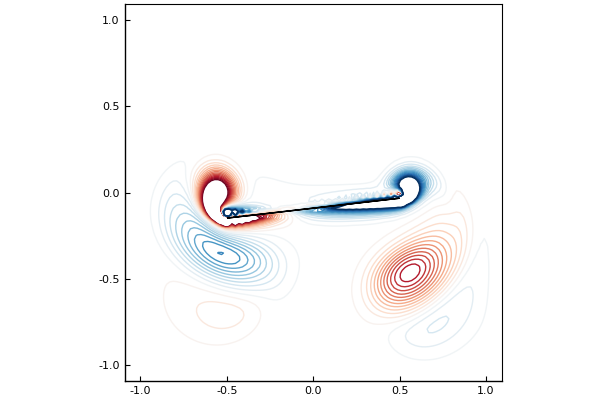

In [31]:
plot(xg,yg,vorticity(uhist[end][1],sys.grid),levels=range(-10,10,length=30),color = :RdBu,clim=(-10,10))
Tr = RigidTransform(uhist[end][2])
Tr(body) # transform the body to the current configuration
plot!(body,linecolor=:black)

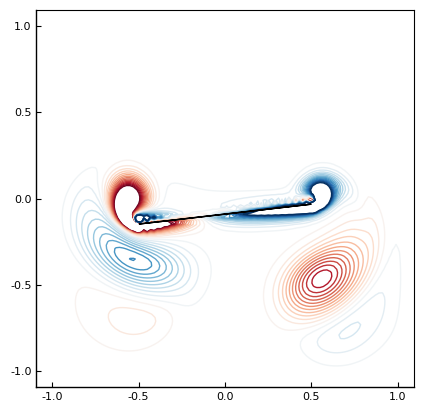

┌ Info: Saved animation to 
│   fn = /Users/jeff/JuliaProjects/ViscousFlow/examples/tmp.gif
└ @ Plots /Users/jeff/.julia/packages/Plots/RsO3g/src/animation.jl:98


Plots.AnimatedGif("/Users/jeff/JuliaProjects/ViscousFlow/examples/tmp.gif")
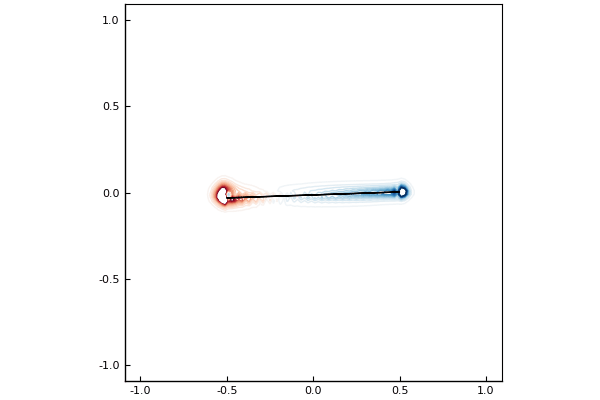

In [24]:
@gif for i = 1:length(uhist)
    plot(xg,yg,vorticity(uhist[i][1],sys.grid),levels=range(-10,10,length=30),color = :RdBu,clim=(-10,10))
    Tr = RigidTransform(uhist[i][2])
    Tr(body) # transform the body to the current configuration
    plot!(body,linecolor=:black)
end

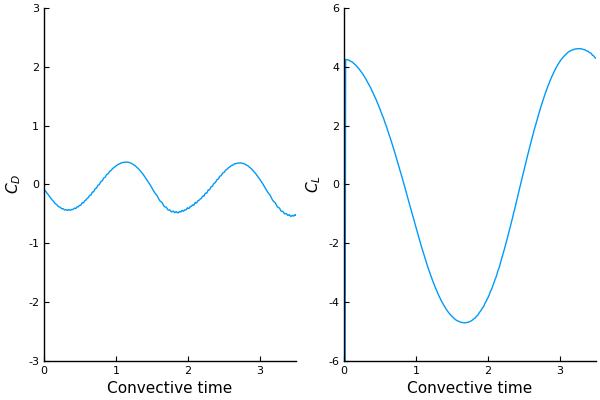

In [25]:
px = plot(thist,2*fx,xlim=(0,Inf),ylim=(-3,3),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,xlim=(0,Inf),ylim=(-6,6),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

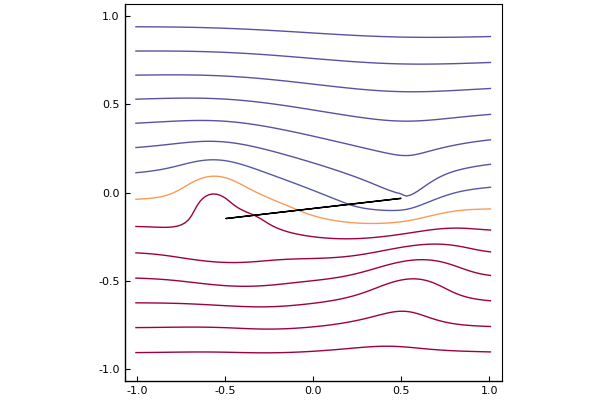

In [30]:
ψ = deepcopy(w₀)
ψ .= streamfunction(u[1],sys) .+ yg'
plot(xg,yg,ψ,trim=1,clim=(-0.1,0.1))
plot!(body,fillcolor=:black,linecolor=:black)